In [1]:
import pandas as pd
import json
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import gc
import joblib
from scipy import stats 
from datetime import timedelta
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from xgboost import plot_importance, plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import numpy as np
import openpyxl
import os
import tensorflow as tf
import yfinance as yf
import warnings
import matplotlib
warnings.filterwarnings("ignore")

In [2]:
def windowing(train, val, window, prediction_scope):
    
    
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    for i in range(len(train)-(WINDOW+PREDICTION_SCOPE)):
        X, y = np.array(train[i:i+WINDOW, :-1]), np.array(train[i+WINDOW+PREDICTION_SCOPE, -1])
        X_train.append(X)
        y_train.append(y)

    for i in range(len(val)-(window+PREDICTION_SCOPE)):
        X, y = np.array(val[i:i+WINDOW, :-1]), np.array(val[i+WINDOW+PREDICTION_SCOPE, -1])
        X_test.append(X)
        y_test.append(y)
        
    
    return X_train, y_train, X_test, y_test

In [3]:
stock_prices = yf.download("AAPL", start="2001-11-30")
SPY = yf.download("SPY", start="2001-11-30")["Close"]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
#FEATURE ENGINEERING
stock_prices["Day"] = stock_prices.index.day
stock_prices["Month"] = stock_prices.index.day
stock_prices["Year"] = stock_prices.index.day
stock_prices["Weekday"] = stock_prices.index.weekday
stock_prices["Upper_Shape"] = stock_prices["High"]-np.maximum(stock_prices["Open"], stock_prices["Close"])
stock_prices["Lower_Shape"] = np.minimum(stock_prices["Open"], stock_prices["Close"])-stock_prices["Low"]
stock_prices["Close_y"] = stock_prices["Close"]
stock_prices.drop("Close",1,  inplace=True)

In [5]:
WINDOW = 15
PREDICTION_SCOPE = 0

In [6]:
train = stock_prices.iloc[:int(len(stock_prices))-WINDOW]
test = stock_prices.iloc[-WINDOW:]

In [7]:
from sklearn.preprocessing import MinMaxScaler

In [8]:
scaler = MinMaxScaler(feature_range=(0, 15))

In [9]:
print(train.shape)
print(test.shape)

(5057, 12)
(15, 12)


In [10]:
train = np.array(train)

In [11]:
train_scale = scaler.fit_transform(train)
test_scale = scaler.fit_transform(test)

In [12]:
train_scale

array([[1.12688220e-02, 1.10591880e-02, 1.12218902e-02, ...,
        5.31545611e-03, 6.71078155e-03, 1.08573109e-02],
       [1.10763545e-02, 1.21488851e-02, 1.13119877e-02, ...,
        7.44046774e-03, 6.41996543e-03, 1.21661141e-02],
       [1.19499614e-02, 1.19132815e-02, 1.18377805e-02, ...,
        1.16934180e-02, 1.31306983e-02, 1.17943118e-02],
       ...,
       [1.49203935e+01, 1.49340274e+01, 1.50000000e+01, ...,
        3.48213678e+00, 1.24182105e+00, 1.49133787e+01],
       [1.48515662e+01, 1.48763019e+01, 1.49671907e+01, ...,
        3.72023742e+00, 1.94444837e+00, 1.49208757e+01],
       [1.48631755e+01, 1.48713542e+01, 1.49629841e+01, ...,
        3.27382709e+00, 1.79739553e-01, 1.48225939e+01]])

In [13]:
X_train, y_train, X_val, y_val = windowing(train_scale[:int(len(train_scale)*0.90)], train_scale[int(len(train_scale)*0.90):], WINDOW, PREDICTION_SCOPE)

In [167]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

X_test = np.array(test_scale[:, :-1])
y_test = np.array(test_scale[:, -1])

#X_train = X_train.reshape(X_train.shape[0], -1)
#X_val = X_val.reshape(X_val.shape[0], -1)
#X_test = X_test.reshape(1, -1)

In [168]:
X_test.shape

(15, 11)

In [169]:
X_train.shape

(4536, 15, 11)

In [17]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[X_train.shape[1], X_train.shape[2]], activation="relu"), 
    tf.keras.layers.Dense(30, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 0.0282 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0282, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=10, callbacks=[lr_schedule],validation_data=[X_val, y_val], verbose=1)

Epoch 1/10
142/142 [==============================] - 1s 3ms/step - loss: 0.6945 - val_loss: 8.1743 - lr: 0.0282
Epoch 2/10
142/142 [==============================] - 0s 1ms/step - loss: 0.6686 - val_loss: 8.2530 - lr: 0.0316
Epoch 3/10
142/142 [==============================] - 0s 1ms/step - loss: 0.6684 - val_loss: 8.1988 - lr: 0.0355
Epoch 4/10
142/142 [==============================] - 0s 1ms/step - loss: 0.6676 - val_loss: 8.4391 - lr: 0.0398
Epoch 5/10
142/142 [==============================] - 0s 1ms/step - loss: 0.6686 - val_loss: 8.2895 - lr: 0.0447
Epoch 6/10
142/142 [==============================] - 0s 1ms/step - loss: 0.6718 - val_loss: 8.3005 - lr: 0.0501
Epoch 7/10
142/142 [==============================] - 0s 1ms/step - loss: 0.6691 - val_loss: 8.4819 - lr: 0.0563
Epoch 8/10
142/142 [==============================] - 0s 1ms/step - loss: 0.6716 - val_loss: 8.3380 - lr: 0.0631
Epoch 9/10
142/142 [==============================] - 0s 1ms/step - loss: 0.6698 - val_loss: 8.1

In [28]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 0.0507 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0507, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=10, callbacks=[lr_schedule],validation_data=[X_val, y_val], verbose=1)

Epoch 1/10
142/142 [==============================] - 4s 13ms/step - loss: 0.0829 - val_loss: 3.4886 - lr: 0.0507
Epoch 2/10
142/142 [==============================] - 1s 10ms/step - loss: 0.0058 - val_loss: 3.2892 - lr: 0.0569
Epoch 3/10
142/142 [==============================] - 1s 10ms/step - loss: 0.0059 - val_loss: 3.1290 - lr: 0.0638
Epoch 4/10
142/142 [==============================] - 1s 10ms/step - loss: 0.0032 - val_loss: 3.1858 - lr: 0.0716
Epoch 5/10
142/142 [==============================] - 1s 10ms/step - loss: 0.0084 - val_loss: 3.2491 - lr: 0.0804
Epoch 6/10
142/142 [==============================] - 1s 10ms/step - loss: 0.0027 - val_loss: 3.0827 - lr: 0.0902
Epoch 7/10
142/142 [==============================] - 1s 10ms/step - loss: 0.0063 - val_loss: 3.3452 - lr: 0.1012
Epoch 8/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0044 - val_loss: 3.1600 - lr: 0.1135
Epoch 9/10
142/142 [==============================] - 1s 9ms/step - loss: 0.0045 - val_lo

In [180]:
y_hat = model.predict(X_val)

In [181]:
mean_absolute_error(y_hat, y_val)

3.4879534631743216

In [165]:
def inverse_transformation(X, y, y_hat):
    
    if X.shape[1]>1:
        new_X = []

        for i in range(len(X)):
            new_X.append(X[i][0])
            
        new_X = np.array(new_X)
        y = np.expand_dims(y, 1)
        
        new_X = pd.DataFrame(new_X)
        y = pd.DataFrame(y)
        y_hat = pd.DataFrame(y_hat)

        real_val = np.array(pd.concat((new_X, y), 1))
        pred_val = np.array(pd.concat((new_X, y_hat), 1))
        
        real_val = pd.DataFrame(scaler.inverse_transform(real_val))
        pred_val = pd.DataFrame(scaler.inverse_transform(pred_val))
        
    else:
        
        X = X.reshape(X.shape[0], X.shape[1]*X.shape[2])
        
        new_X = pd.DataFrame(X)
        y = pd.DataFrame(y)
        y_hat = pd.DataFrame(y_hat)
        y_hat = pd.concat((y, y_hat))
        y_hat.index = range(len(y_hat))
        
        real_val = np.array(pd.concat((new_X, y), 1))
        pred_val = np.array(pd.concat((new_X, y_hat), 1))
        
        pred_val = pd.DataFrame(scaler.inverse_transform(pred_val))
        real_val = pd.DataFrame(scaler.inverse_transform(real_val))
        
    return real_val, pred_val

In [31]:
real_val, pred_val = inverse_transformation(X_val, y_val, y_hat)

In [32]:
pred_val

,0,1,2,3,4,5,6,7,8,9,10,11
0,171.681634,172.990364,169.005050,170.202206,6.589901e+07,30.066667,30.066667,30.066667,0.0,0.250886,0.270501,170.609795
1,171.693463,173.012965,169.106458,170.259299,6.513980e+07,31.000000,31.000000,31.000000,1.0,0.103860,0.125521,170.604487
2,171.852270,173.170943,169.240177,170.438891,6.574765e+07,3.933333,3.933333,3.933333,3.0,0.132233,0.149747,170.597460
3,171.875172,173.170486,169.271071,170.360623,6.593772e+07,4.866667,4.866667,4.866667,4.0,0.506241,0.134605,170.549261
4,171.790610,173.156332,169.182633,170.424147,6.544801e+07,7.666667,7.666667,7.666667,0.0,0.120626,0.149369,170.472347
...,...,...,...,...,...,...,...,...,...,...,...,...
486,180.377010,181.302693,177.164455,180.206999,6.576972e+07,3.933333,3.933333,3.933333,3.0,0.326977,0.252332,171.081888
487,180.908548,181.372095,177.345576,179.998083,6.544014e+07,4.866667,4.866667,4.866667,4.0,0.584914,0.431002,171.068216
488,180.935728,181.638740,177.775738,180.376745,6.525710e+07,7.666667,7.666667,7.666667,0.0,1.420627,0.111514,171.085049
489,181.417938,181.976611,178.158733,181.014375,6.548339e+07,8.600000,8.600000,8.600000,1.0,0.306345,0.222049,171.073194


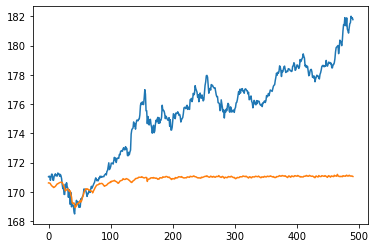

In [33]:
plt.figure()

plt.plot(real_val[11])
plt.plot(pred_val[11])

## Prediction

In [170]:
X_test_formula = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [171]:
X_test.shape

(15, 11)

In [172]:
X_test = X_test.reshape(1, X_test_formula.shape[0], X_test_formula.shape[2])

In [173]:
X_test.shape

(1, 15, 11)

In [174]:
y_hat = model.predict(X_test)

In [175]:
real_val, pred_val = inverse_transformation(X_test_formula, y_test, y_hat)

In [176]:
pred_val

,0,1,2,3,4,5,6,7,8,9,10,11
0,178.089996,179.229996,177.259995,177.570007,64062300.0,31.0,31.0,31.0,4.0,1.139999,0.310013,177.570007
1,177.830002,182.880005,177.710007,182.009995,104487900.0,3.0,3.0,3.0,0.0,0.870010,0.119995,182.009995
2,182.630005,182.940002,179.119995,179.699997,99310400.0,4.0,4.0,4.0,1.0,0.309998,0.580002,179.699997
3,179.610001,180.169998,174.639999,174.919998,94537600.0,5.0,5.0,5.0,2.0,0.559998,0.279999,174.919998
4,172.699997,175.300003,171.639999,172.000000,96904000.0,6.0,6.0,6.0,3.0,2.600006,0.360001,172.000000
5,172.889999,174.139999,171.029999,172.169998,86580100.0,7.0,7.0,7.0,4.0,1.250000,1.139999,172.169998
6,169.080002,172.500000,168.169998,172.190002,106765600.0,10.0,10.0,10.0,0.0,0.309998,0.910004,172.190002
7,172.320007,175.179993,170.820007,175.080002,76138300.0,11.0,11.0,11.0,1.0,0.099991,1.500000,175.080002
8,176.119995,177.179993,174.820007,175.529999,74805200.0,12.0,12.0,12.0,2.0,1.059998,0.709991,175.529999
9,175.779999,176.619995,171.789993,172.190002,84505800.0,13.0,13.0,13.0,3.0,0.839996,0.400009,172.190002


In [178]:
real_val

,0,1,2,3,4,5,6,7,8,9,10,11
0,178.089996,179.229996,177.259995,177.570007,64062300.0,31.0,31.0,31.0,4.0,1.139999,0.310013,177.570007
1,177.830002,182.880005,177.710007,182.009995,104487900.0,3.0,3.0,3.0,0.0,0.870010,0.119995,182.009995
2,182.630005,182.940002,179.119995,179.699997,99310400.0,4.0,4.0,4.0,1.0,0.309998,0.580002,179.699997
3,179.610001,180.169998,174.639999,174.919998,94537600.0,5.0,5.0,5.0,2.0,0.559998,0.279999,174.919998
4,172.699997,175.300003,171.639999,172.000000,96904000.0,6.0,6.0,6.0,3.0,2.600006,0.360001,172.000000
5,172.889999,174.139999,171.029999,172.169998,86580100.0,7.0,7.0,7.0,4.0,1.250000,1.139999,172.169998
6,169.080002,172.500000,168.169998,172.190002,106765600.0,10.0,10.0,10.0,0.0,0.309998,0.910004,172.190002
7,172.320007,175.179993,170.820007,175.080002,76138300.0,11.0,11.0,11.0,1.0,0.099991,1.500000,175.080002
8,176.119995,177.179993,174.820007,175.529999,74805200.0,12.0,12.0,12.0,2.0,1.059998,0.709991,175.529999
9,175.779999,176.619995,171.789993,172.190002,84505800.0,13.0,13.0,13.0,3.0,0.839996,0.400009,172.190002


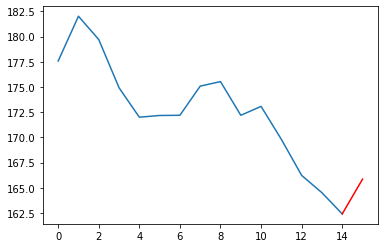

In [179]:
plt.figure()

plt.plot(real_val[11])
plt.plot([14, 15],pred_val.iloc[-2:, 11], color="red")

In [253]:
new_val = []

for i in range(len(X_val)):
    new_val.append(X_val[i][0])

In [256]:
new_val = np.array(new_val)

In [272]:
y_val = np.expand_dims(y_val, 1)

In [277]:
new_val = pd.DataFrame(new_val)

In [281]:
y_val = pd.DataFrame(y_val)
y_hat = pd.DataFrame(y_hat)

In [283]:
real_val = np.array(pd.concat((new_val, y_val), 1))
pred_val = np.array(pd.concat((new_val, y_hat), 1))

In [285]:
real_val = pd.DataFrame(scaler.inverse_transform(real_val))
pred_val = pd.DataFrame(scaler.inverse_transform(pred_val))


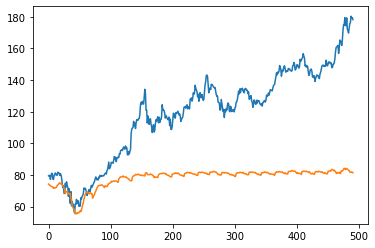

In [289]:
plt.figure()

plt.plot(real_val[11])
plt.plot(pred_val[11])

In [305]:
model.predict(X_test)

array([[0.6260625],
       [0.6260625],
       [0.6260625],
       [0.6260625],
       [0.6260625],
       [0.6260625],
       [0.6260625],
       [0.6260625],
       [0.6260625],
       [0.6260625],
       [0.6260625],
       [0.6260625],
       [0.6260625],
       [0.6260625],
       [0.6260625]], dtype=float32)

In [259]:
old_val = old_val[:X_val.shape[0]]

In [260]:
old_val

array([[ 5.98157601,  6.01477591,  5.97953328, ...,  0.87054555,
         1.7320221 ,  6.05059184],
       [ 5.99131963,  6.03518589,  6.06996904, ...,  0.02232052,
         0.16748515,  6.09494336],
       [ 6.12213255,  6.17785131,  6.18921867, ...,  0.18601187,
         0.42891657,  6.23445276],
       ...,
       [13.60438512, 13.82486806, 13.80119699, ...,  7.61903897,
         0.01633089, 13.74983191],
       [14.00159287, 14.12998979, 14.14275049, ...,  1.19050322,
         1.20915926, 14.23790448],
       [14.25451202, 14.49118864, 14.34128914, ...,  2.61906168,
         2.33661419, 14.56273252]])

In [247]:
scaler.inverse_transform(old_val)

array([[7.23649979e+01, 7.31725006e+01, 7.13050003e+01, ...,
        2.92503357e-01, 1.05999756e+00, 7.28799973e+01],
       [7.24824982e+01, 7.34199982e+01, 7.23799973e+01, ...,
        7.49969482e-03, 1.02500916e-01, 7.34124985e+01],
       [7.40599976e+01, 7.51500015e+01, 7.37975006e+01, ...,
        6.25000000e-02, 2.62496948e-01, 7.50875015e+01],
       ...,
       [1.80160004e+02, 1.81330002e+02, 1.78529999e+02, ...,
        1.16999817e+00, 7.59994507e-01, 1.79289993e+02],
       [1.79330002e+02, 1.80630005e+02, 1.78139999e+02, ...,
        1.25000000e+00, 1.19000244e+00, 1.79380005e+02],
       [1.79470001e+02, 1.80570007e+02, 1.78089996e+02, ...,
        1.10000610e+00, 1.10000610e-01, 1.78199997e+02]])

In [315]:
X_test.shape

(15, 1, 11)

In [159]:
y_hat = model.predict(X_val)

In [202]:
np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

ValueError: cannot reshape array of size 81015 into shape (491,15,1)

In [200]:
pd.concat((X_val, y_hat), 1)

TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

In [197]:
y_hat

array([[6.164195 ],
       [6.1417875],
       [6.108801 ],
       [6.072532 ],
       [6.065097 ],
       [6.0364084],
       [6.026379 ],
       [6.011125 ],
       [5.9370947],
       [5.9785624],
       [5.9676113],
       [5.963982 ],
       [5.98785  ],
       [6.005183 ],
       [6.099942 ],
       [6.1162224],
       [6.1536236],
       [6.2083387],
       [6.236442 ],
       [6.182153 ],
       [6.17332  ],
       [6.1676   ],
       [6.140149 ],
       [6.0872965],
       [6.0273433],
       [5.968144 ],
       [5.8492556],
       [5.6695523],
       [5.7582245],
       [5.763562 ],
       [5.7752743],
       [5.758658 ],
       [5.6443443],
       [5.647749 ],
       [5.6524734],
       [5.6693916],
       [5.388973 ],
       [5.3451834],
       [5.0069146],
       [4.946752 ],
       [4.892958 ],
       [4.846324 ],
       [4.7293234],
       [4.5953975],
       [4.6139717],
       [4.5993757],
       [4.666244 ],
       [4.6277432],
       [4.6660557],
       [4.6611643],


In [189]:
X_val.reshape(X_val.shape[0], -1).shape

(491, 165)

In [193]:
sc = MinMaxScaler()

In [196]:
trans = sc.fit_transform(stock_prices.iloc[:, -1])

ValueError: Expected 2D array, got 1D array instead:
array=[  0.36464301   0.380357     0.375893   ... 166.22999573 164.50999451
 162.41000366].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [190]:
new_val[-1]

(11,)

In [75]:
y_hat = y_hat.reshape(1, -1)

In [191]:
scaler.inverse_transform(y_hat)

ValueError: non-broadcastable output operand with shape (491,1) doesn't match the broadcast shape (491,12)

In [82]:
X_train.shape

(4536, 15, 11)

In [69]:
X_test = X_test.reshape(1, -1)

In [70]:
model.predict(X_test)

ValueError: in user code:

    File "C:\Users\Usuario\anaconda3\lib\site-packages\keras\engine\training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\Usuario\anaconda3\lib\site-packages\keras\engine\training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Usuario\anaconda3\lib\site-packages\keras\engine\training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\Usuario\anaconda3\lib\site-packages\keras\engine\training.py", line 1572, in predict_step
        return self(x, training=False)
    File "C:\Users\Usuario\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Usuario\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 213, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential_14" (type Sequential).
    
    Input 0 of layer "lstm_10" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, None)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, None), dtype=float32)
      • training=False
      • mask=None


In [28]:
X_train.shape

(4536, 15, 11)

In [34]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(100, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(tf.keras.layers.Dropout(.2))
model.add(tf.keras.layers.LSTM(100, activation='relu'))
model.add(tf.keras.layers.Dropout(.2))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

In [35]:
model.fit(X_train, y_train, epochs=20, verbose=1)

Epoch 1/20
142/142 [==============================] - 3s 13ms/step - loss: 1555459718774784.0000
Epoch 2/20
142/142 [==============================] - 2s 13ms/step - loss: 40867960193024.0000
Epoch 3/20
142/142 [==============================] - 2s 14ms/step - loss: 3386126106624.0000
Epoch 4/20
142/142 [==============================] - 2s 13ms/step - loss: 1790299602944.0000
Epoch 5/20
142/142 [==============================] - 2s 14ms/step - loss: 3711045992448.0000
Epoch 6/20
142/142 [==============================] - 2s 14ms/step - loss: 779720851456.0000
Epoch 7/20
 37/142 [======>.......................] - ETA: 1s - loss: 657917542400.0000

KeyboardInterrupt: 

In [24]:
model.predict(X_val)

array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
      

In [18]:
results

array([], dtype=float64)

In [ ]:
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())